# Probability of default: credit scoring model

This model uses a Kaggle dataset containing data about credit repayment difficulty rates among customers.

**Kaggle description:**

Improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years. 

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.

Historical data are provided on 250,000 borrowers.

---

The variables are the following:

**SeriousDlqin2yrs** Person experienced 90 days past due delinquency or worse (Target variable / label)

**RevolvingUtilizationOfUnsecuredLines**: Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

**age** Age of borrower in years

**NumberOfTime30-59DaysPastDueNotWorse**: Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

**DebtRatio**: Monthly debt payments, alimony,living costs divided by monthy gross income

**MonthlyIncome**: Monthly income

**NumberOfOpenCreditLinesAndLoans**: Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

**NumberOfTimes90DaysLate**: Number of times borrower has been 90 days or more past due.

**NumberRealEstateLoansOrLines**: Number of mortgage and real estate loans including home equity lines of credit

**NumberOfTime60-89DaysPastDueNotWorse**: Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

**NumberOfDependents**: Number of dependents in family excluding themselves (spouse, children etc.)

---

We will be using a random forest classifier for two reasons: firstly, because it would allow us to quickly and easily change the output to a simple binary classification problem. Secondly, because the predict_proba functionality allows us to output a probability score (probability of 1), this score is what we will use for predicting the probability of 90 days past due delinquency or worse in 2 years time.

---

Furthermore, we will predominantly be adopting a quantiles based approach in order to streamline the process as much as possible so that hypothetical credit checks can be returned as easily and as quickly as possible.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('cs-training.csv',index_col=0)
df.head(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


___

# 1. Preprocessing Data (Tiền xử lý dữ liệu)

**Bước 1. Kiểm tra dữ liệu bị missing value**

In [3]:
df.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

**Bước 2. Kiểm tra phân bổ của các trường bị missing**

Cần phải lưu ý rằng sau khi xử lý các trường dữ liệu bị missing value (có thể là thêm vào giá trị mới, xóa bỏ,...) thì BẮT BUỘC các trường đó phải có phân bổ dữ liệu như ban đầu. Việc này nhằm đảm bảo tính toàn vẹn, không thiên vị của bộ dữ liệu.

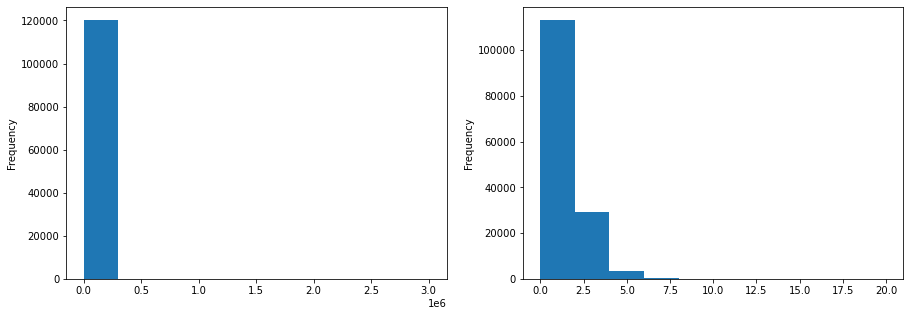

In [4]:
fig, axes = plt.subplots(1,2, figsize = (15,5))

df['MonthlyIncome'].plot(kind='hist',ax=axes[0],xlabel='MonthlyIncome')
df['NumberOfDependents'].plot(kind='hist',ax=axes[1],xlabel='NumberOfDependents')
plt.show()

**Bước 3. Fill các trường bị missing value**

In [5]:
df['MonthlyIncome'] = df.MonthlyIncome.fillna(df.MonthlyIncome.median())
df['NumberOfDependents'] = df.NumberOfDependents.fillna(df.NumberOfDependents.median())

Sau khi fillna, chúng ta cần kiểm tra lại bộ dữ liệu xem còn missing value nữa hay không.

In [6]:
df.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

Như vậy không còn trường dữ liệu nào bị missing value nữa

**Bước 4. Kiểm tra lại phân bổ của các trường vừa fill dữ liệu vào**

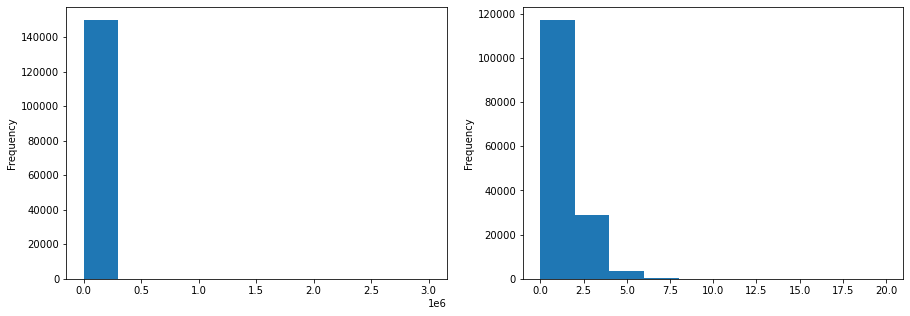

In [7]:
fig, axes = plt.subplots(1,2, figsize = (15,5))

df['MonthlyIncome'].plot(kind='hist',ax=axes[0],xlabel='MonthlyIncome')
df['NumberOfDependents'].plot(kind='hist',ax=axes[1],xlabel='NumberOfDependents')
plt.show()

Như vậy, phân bổ dữ liệu không có sự thay đổi.

**Bước 5. Kiểm tra các dữ liệu bị trùng lắp và loại bỏ nếu có**

In [8]:
df.duplicated().sum()

767

Như vậy có 767 các quan sát (hàng) bị trùng lắp, chúng ta cần tiến hành loại bỏ các quan sát này

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

Và không còn quan sát nào bị trùng lắp nữa

# 2. Data Exploration (Khám phá dữ liệu)

**Kiểm tra *thống kê mô tả* các trường của bộ dữ liệu**

In [11]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149233.000000,149233.000000,149233.000000,149233.000000,149233.000000,1.492330e+05,149233.000000,149233.000000,149233.000000,149233.000000,149233.000000
mean,0.067036,6.077045,52.298145,0.388386,354.808254,6.426774e+03,8.488082,0.232435,1.023473,0.206811,0.741177
std,0.250085,250.396053,14.714050,3.779712,2042.891693,1.292246e+04,5.134233,3.752133,1.130304,3.736132,1.108596
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030210,41.000000,0.000000,0.178098,3.900000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154285,52.000000,0.000000,0.368578,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.555959,63.000000,0.000000,0.877090,7.409000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [12]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

**Kiểm tra trường dữ liệu *SeriousDlqin2yrs***

In [13]:
df.groupby('SeriousDlqin2yrs')['SeriousDlqin2yrs'].count()

SeriousDlqin2yrs
0    139229
1     10004
Name: SeriousDlqin2yrs, dtype: int64

**Visualization của trường *SeriousDlqin2yrs***

***Bar chart***

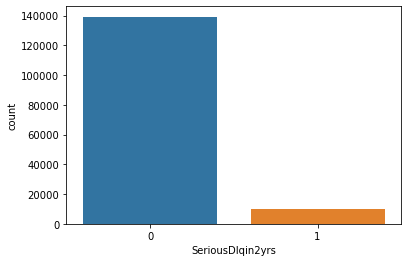

In [14]:
sns.countplot(data=df, x='SeriousDlqin2yrs')
plt.show()

***Pie chart***

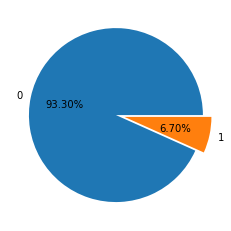

In [15]:
plt.pie(x=df.groupby('SeriousDlqin2yrs')['SeriousDlqin2yrs'].count().values, 
       explode=(0,0.1), labels=['0','1'], autopct='%.2f%%')
plt.show()

Có sự khác biệt rất lớn giữa người trả được nợ và người không trả được nợ (vỡ nợ)

**→ Chắc chắn ảnh hưởng đến mô hình phân tích về sau**

**Mối quan hệ giữa** *trả được nợ/vỡ nợ* **đối với** *thu nhập, tỷ lệ nợ, tuổi và các yếu tố khác*

In [16]:
df.groupby('SeriousDlqin2yrs')[['RevolvingUtilizationOfUnsecuredLines',
                               'MonthlyIncome','DebtRatio','age']].agg(['mean','median','max'])

RevolvingUtilizationOfUnsecuredLines                     \
                                                 mean    median      max   
SeriousDlqin2yrs                                                           
0                                            6.199365  0.133433  50708.0   
1                                            4.374687  0.837421   8328.0   

                 MonthlyIncome                      DebtRatio            \
                          mean  median        max        mean    median   
SeriousDlqin2yrs                                                          
0                  6486.625215  5400.0  3008750.0  359.050473  0.364808   
1                  5593.804178  5222.5   250000.0  295.767874  0.429075   

                                  age              
                       max       mean median  max  
SeriousDlqin2yrs                                   
0                 329664.0  52.753966   52.0  109  
1                  38793.0  45.954318   45.5  101

**Nhận xét:**
- *MonthlyIncome*: những người trả được nợ có thu nhập nhập cao hơn
- *DebtRatio*: tỷ lệ nợ càng cao thì càng ít vỡ nợ
- *age*: tuổi càng cao thì càng ít vỡ nợ

*[0]: trả được nợ*              *[1]: không trả được nợ (vỡ nợ)*

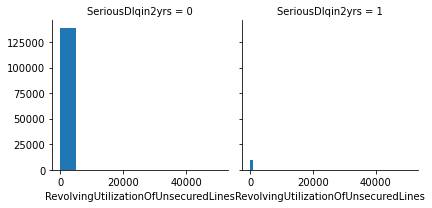

In [17]:
g=sns.FacetGrid(col='SeriousDlqin2yrs', data=df)
g.map(plt.hist,'RevolvingUtilizationOfUnsecuredLines')
plt.show()

Đối với những người trả được nợ thì có số dư tài khoản cuối kỳ cao hơn rất nhiều so với những người không trả được nợ

***Xem xét các yếu tố khác ở 2 nhóm người này***

In [18]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [19]:
overdue = df.groupby('SeriousDlqin2yrs')[['NumberOfTime30-59DaysPastDueNotWorse',
                               'NumberOfTimes90DaysLate',
                               'NumberOfTime60-89DaysPastDueNotWorse']].agg(['mean'])
overdue.head()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse
,mean,mean,mean
SeriousDlqin2yrs,,,
0,0.254854,0.109101,0.100590
1,2.246801,1.948920,1.685126


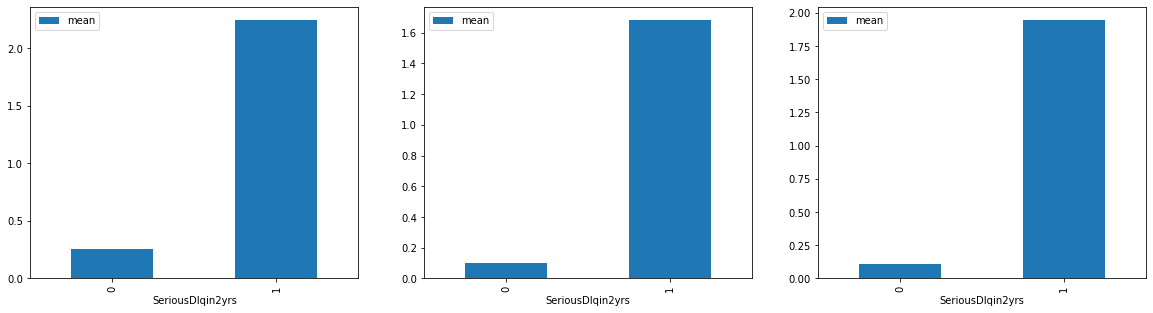

In [20]:
_, axes = plt.subplots(1,3, figsize=(20,5))

overdue['NumberOfTime30-59DaysPastDueNotWorse'].plot(kind='bar', ax=axes[0])
overdue['NumberOfTime60-89DaysPastDueNotWorse'].plot(kind='bar', ax=axes[1])
overdue['NumberOfTimes90DaysLate'].plot(kind='bar', ax=axes[2])

plt.show()

**Nhận xét**
- Những người trả được nợ có số lần trả nợ vượt quá tiêu chuẩn thấp hơn nhiều so với những người không trả được nợ

In [21]:
df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

## Tìm correlation giữa các biến

In [22]:
df[['NumberOfTime30-59DaysPastDueNotWorse',
   'NumberOfTimes90DaysLate',
   'NumberOfTime60-89DaysPastDueNotWorse']].corr()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse
NumberOfTime30-59DaysPastDueNotWorse,1.000000,0.979702,0.983910
NumberOfTimes90DaysLate,0.979702,1.000000,0.991059
NumberOfTime60-89DaysPastDueNotWorse,0.983910,0.991059,1.000000


Chúng ta nhận thấy corr của các biến là như nhau (=1 hoặc ~1) 
- Thì lượng thông tin mô hình nhận được là gấp *n biến tương quan như nhau* trong mô hình lên. Nhưng trong thực tế thì chỉ cần chọn 1 trong 3 biến là đủ. Cụ thể, trong mô hình hệ số trước x là 1 thì ta ghi là *x*, nhưng việc đưa biến có tương quan như nhau vào sẽ dẫn đến việc tăng hệ số này lên. Đưa thêm 3 biến có tương quan y hệt x thì lúc này mô hình có hệ số trước x là 4x. **Việc này có vẻ không có ý nghĩa và mô hình lúc này bị overfit**.
    
- Đồng thời việc này cũng **ảnh hưởng đến tính chính xác khi xác định các biến nào là quan trọng nhất đối với biến phụ thuộc trong mô hình**. Dựa vào việc cố định các b,c trong mô hình và xét biến a để đưa ra giá trị phụ thuộc của biến a đối với mô hình lúc này không còn đúng nữa. Do biến a,b,c lúc này có tương quan như nhau. 

**Do nhận thấy các biến này có tương quan là gần như nhau nên cuối cùng, chúng ta chỉ cần chọn 1 trong 3 biến bên dưới là đủ** 
- 'NumberOfTime30-59DaysPastDueNotWorse'
- 'NumberOfTimes90DaysLate'
- 'NumberOfTime60-89DaysPastDueNotWorse'

*Một cách trực quan hóa hơn, chúng ta có thể dùng **đồ thị Heatmap** để quan sát giúp cho việc quan sát thuận tiện và nhanh chóng hơn*

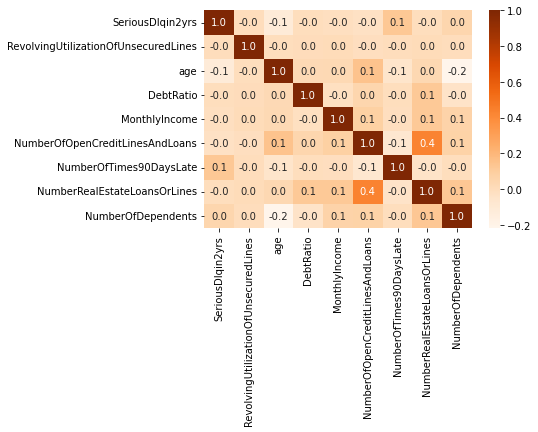

In [23]:
columns = ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age','DebtRatio', 
           'MonthlyIncome','NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
           'NumberRealEstateLoansOrLines','NumberOfDependents']
sns.heatmap(df[columns].corr(),annot=True,fmt='0.1f',cmap='Oranges')
plt.show()

**Như vậy, trong mô hình không còn các biến độc lập nào có tương quan với nhau nữa. Nói cách khác, lúc này các biến độc lập trong mô hình là hoàn toàn độc lập và không ảnh hưởng gì với nhau.**

# 3. Tạo mô hình Machine Learning 
## Tạo dataframe gồm các biến độc lập

**Tạo bảng bao gồm các Features (biến độc lập)**

In [24]:
new_df=df[columns].copy()

**Lưu ý: Phải kiểm tra lại xem các scale có tương đồng chưa**
- Lưu ý rằng nếu scale không tương đồng sẽ dẫn đến việc mô hình bị bias và  học máy trở thành 'học dở'

In [25]:
new_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfDependents
count,149233.000000,149233.000000,149233.000000,149233.000000,1.492330e+05,149233.000000,149233.000000,149233.000000,149233.000000
mean,0.067036,6.077045,52.298145,354.808254,6.426774e+03,8.488082,0.232435,1.023473,0.741177
std,0.250085,250.396053,14.714050,2042.891693,1.292246e+04,5.134233,3.752133,1.130304,1.108596
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030210,41.000000,0.178098,3.900000e+03,5.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154285,52.000000,0.368578,5.400000e+03,8.000000,0.000000,1.000000,0.000000
75%,0.000000,0.555959,63.000000,0.877090,7.409000e+03,11.000000,0.000000,2.000000,1.000000
max,1.000000,50708.000000,109.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,20.000000


**Nhận xét**

*income so với các biến khác có giá trị lệch nhau quá nhiều: income thì có đơn vị là triệu trong khi đó các feature còn lại không đến mức đó*

**→  Tiến hành việc chuẩn hóa (normalization)các feature trong mô hình**

## Normalization

- Normalization: MinMaxScaler 
- Standardization: StandardScaler 

***Giá trị của x sau khi được chuẩn hóa bằng MinMaxScaler***
$$\text{X}_{scaled}=\frac{X_{max} - X_i}{X_{max}-X_{min}}$$

*- Đối với biến độc lập có giá trị 0 và 1 (biến nhị phân) thì phương pháp MinMaxScaler trả lại 0 nếu ban đầu biến đó bằng 1 và ngược lại trả lại 1 nếu ban đầu biến đó bằng 0. Vì khoảng cách giữa xmin và xmax sau khi chuẩn hóa vẫn là 0 và 1. Nên phương pháp này sẽ không hữu ích đối với biến nhị phân.*

***Giá trị của x sau khi được chuẩn hóa bằng StandardScaler***
$$\text{X}_{scaled}=\frac{X_i - \bar{X}}{\sigma}$$

--

**Chọn MinMaxScaler để chuẩn hóa features**

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [27]:
scaler=MinMaxScaler()
new_df_arr = scaler.fit_transform(new_df)

**Kiểm tra lại bộ dữ liệu xem có vấn đề gì sau khi chuẩn hóa không**

***Giá trị nhỏ nhất của 9 biến độc lập***

In [28]:
new_df_arr.min(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

***Giá trị lớn nhất của 9 biến độc lập***

In [29]:
new_df_arr.max(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

**Nhận xét**
- Các biến độc lập lúc này chỉ đi từ 0 đến 1 và không có giá trị na.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(new_df_arr[:,1:],new_df_arr[:,0], test_size=0.15,
                                                  shuffle=True, random_state=4)

**Đảm bảo số lượng dòng của X_train = y_train; X_test = y_test**

In [31]:
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

Nếu các dòng bằng nhau thì Python không trả về kết quả gì

## Chaỵ vòng lặp cho các thuật toán Machine learning
### Các thuật toán sử dụng bao gồm: hồi quy logistic, random forest, naive bayes, adaboost classifier, kneighbors classifer, gradient boosting

In [32]:
algos = {'logit':LogisticRegression(),
         'rf':RandomForestClassifier(), 
         'bayes':BernoulliNB(), 
         'ada':AdaBoostClassifier(), 
         'knn':KNeighborsClassifier(),
         'gradient_boosting': GradientBoostingClassifier()}

In [33]:
evaluation = {}
for key in  algos:
    ml = algos.get(key)
    ml.fit(X_train,y_train)
    evaluation.update({key:[recall_score(y_test, ml.predict(X_test)),
                             precision_score(y_test, ml.predict(X_test)),
                             f1_score(y_test, ml.predict(X_test)),
                             accuracy_score(y_test, ml.predict(X_test))]})
    
results = pd.DataFrame(evaluation, index=['recall','precision','f1','accuracy']) * 100
results

,logit,rf,bayes,ada,knn,gradient_boosting
recall,1.563518,15.960912,12.442997,15.048860,10.618893,15.700326
precision,70.588235,54.083885,45.584726,51.333333,48.948949,57.244656
f1,3.059273,24.647887,19.549642,23.274559,17.451820,24.642127
accuracy,93.205271,93.308019,92.977440,93.196337,93.111459,93.415233


Chúng ta có các xác suất dự báo vỡ nợ như sau:

In [34]:
ml.predict_proba(X_test)[:,1]

array([0.03322644, 0.03940447, 0.03970689, ..., 0.04995774, 0.01850717,
       0.01670386])

Tuy nhiên, máy mặc định lớn hơn 0.5 là vỡ nợ. Nhưng, trong thực tế, chúng ta muốn các xác suất này lớn hơn *thres* thì mới thực sự vỡ nợ.

In [35]:
thres = 0.6
print(classification_report(y_test,np.where(ml.predict_proba(X_test)[:,1] > thres,1,0)))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     20850
         1.0       0.67      0.07      0.13      1535

    accuracy                           0.93     22385
   macro avg       0.80      0.53      0.55     22385
weighted avg       0.92      0.93      0.91     22385



In [36]:
thres = 0.7
print(classification_report(y_test,np.where(ml.predict_proba(X_test)[:,1] > thres,1,0)))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     20850
         1.0       0.60      0.02      0.03      1535

    accuracy                           0.93     22385
   macro avg       0.77      0.51      0.50     22385
weighted avg       0.91      0.93      0.90     22385



**Nhận xét:**
- Khi thres càng cao thì giá trị *precision* và *recall* của [1] càng giảm do tính bất cân xứng giữa 2 nhóm [0] và [1] ngay từ đầu.